In [20]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 11 06:02:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    51W / 400W |    958MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [43]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np 
import pickle
import pandas as pd
import torch
import time
torch.cuda.empty_cache()

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:8000
start_time = time.time()
!python "/content/drive/My Drive/CSDI-main/exe_financial.py" --testmissingratio 0.2 --nsample 40
print("--- %s seconds ---" % (time.time() - start_time))

Namespace(config='/content/drive/My Drive/CSDI-main/config/base.yaml', device='cuda:0', modelfolder='', nfold=0, nsample=40, seed=1, testmissingratio=0.2, unconditional=False)
{
    "train": {
        "epochs": 200,
        "batch_size": 16,
        "lr": 0.001
    },
    "diffusion": {
        "layers": 4,
        "channels": 64,
        "nheads": 8,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50,
        "schedule": "quad"
    },
    "model": {
        "is_unconditional": false,
        "timeemb": 128,
        "featureemb": 16,
        "target_strategy": "random",
        "test_missing_ratio": 0.2
    }
}
model folder: /content/drive/My Drive/CSDI-main/save/financial_fold0_20221211_062332/
debug checkpoint
/content/drive/.shortcut-targets-by-id/1vZAu8qk9F_29XXhpyWu37HzUqjO5HEsl/CSDI-main/dataset_financial.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple 

In [34]:
# financial_fold0_20221211_011943 this one is really nice

datafolder = 'financial_fold0_20221211_060348' # set the folder name
nsample = 5 # number of generated sample

path = '/content/drive/My Drive/CSDI-main/save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

    print(samples.shape)
all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

np_samples = samples.cpu().detach().numpy()

np_samples = np.squeeze(np_samples)

torch.Size([1, 5, 3192, 5])


In [35]:
sample_mean = np.zeros([1,L,K])
sample_std = np.zeros([1,L,K])

sample_mean = np.mean(np_samples, axis=0)
#print(sample_mean.shape)

sample_std = np.std(np_samples, axis=0)
#print(sample_std.shape)

samples_new = np.zeros([nsample,L,K])
samples_new = np.repeat(sample_mean[np.newaxis, :, :], nsample, axis=0)

samples_full = np.zeros([1,nsample,L,K])
samples_full = np.repeat(samples_new[np.newaxis,:, :, :],1, axis=0)

tor_sample_mean = torch.tensor(samples_full)
print(tor_sample_mean.shape)

torch.Size([1, 5, 3192, 5])


In [36]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp = []
for q in qlist:
    #quantiles_imp.append(get_quantile(tor_sample_mean, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)
    

(1200.0, 1300.0)

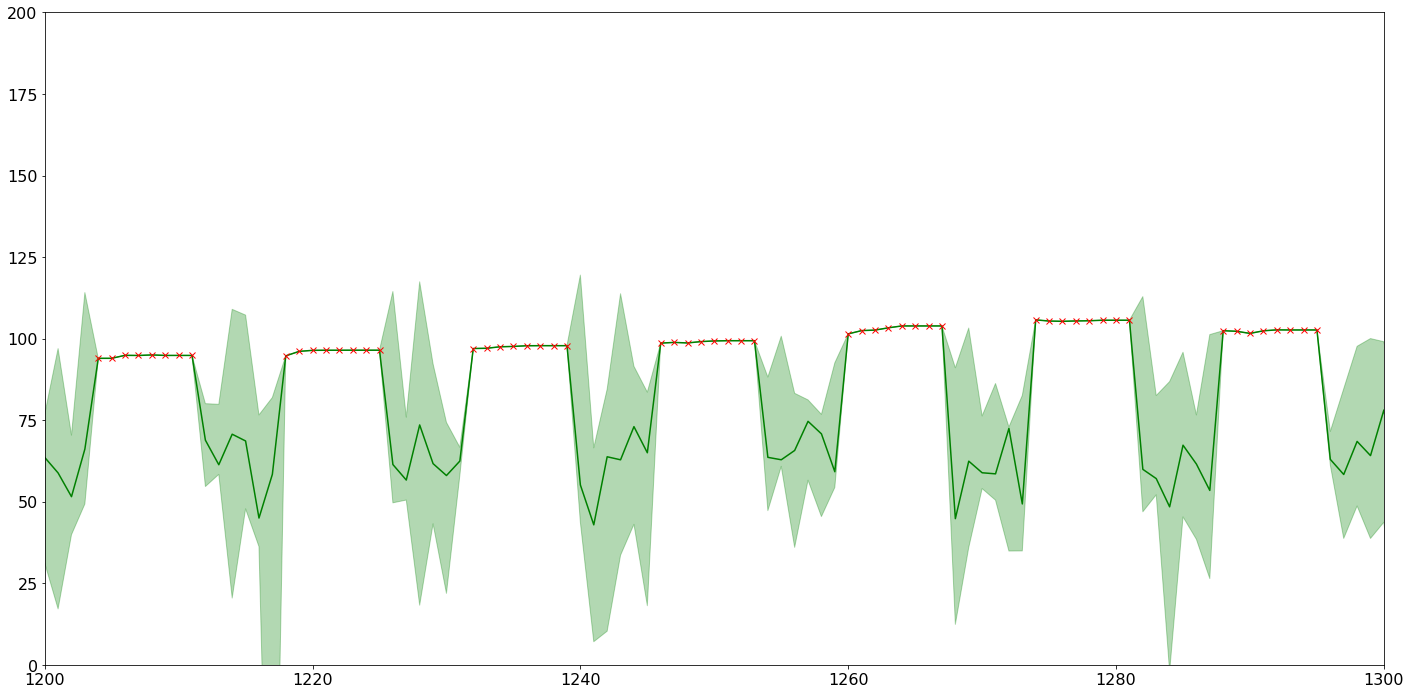

In [37]:
dataind = 0 #change to visualize a different time-series sample
target = 0 # 0 for Px 2 for EURUSD
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(24.0, 12.0))
#fig.delaxes(axes[-1][-1])

"""  >>> We only care about Px so I did not plot the other graphs <<< 
for k in range(K):  # iterates over the features
  df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
  df = df[df.y != 0]
  df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
  df2 = df2[df2.y != 0]
  row = k % 5
  col = k // 5
  axes[row][col].plot(range(0, L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
  axes[row][col].fill_between(range(0, L), quantiles_imp[0][dataind,:,k], quantiles_imp[4][dataind,:,k], color='g', alpha=0.3)
  axes[row][col].plot(df.x.iloc[:159], df.val.iloc[:159], color = 'b',marker = 'o', linestyle='None')
  axes[row][col].plot(df2.x.iloc[:159], df2.val.iloc[:159], color = 'r',marker = 'x', linestyle='None')
  axes[row][col].set_ylim([0,300])
  axes[row][col].set_xlim([0,30])
  break
  if col == 0:
      plt.setp(axes[row, 0], ylabel='value')
  if row == -1:
      plt.setp(axes[-1, col], xlabel='time')
"""
df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,target], "y":all_evalpoint_np[dataind,:,target]})
df = df[df.y != target]
df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,target], "y":all_given_np[dataind,:,target]})
df2 = df2[df2.y != target]
plt.plot(range(0, L), quantiles_imp[2][dataind,:,target], color = 'g',linestyle='solid',label='CSDI')
plt.fill_between(range(0, L), quantiles_imp[0][dataind,:,target], quantiles_imp[4][dataind,:,target], color='g', alpha=0.3)
plt.plot(df.x, df.val, color = 'b',marker = 'o', linestyle='None')
plt.plot(df2.x, df2.val, color = 'r',marker = 'x', linestyle='None')
plt.ylim([0,200])
plt.xlim([1200,1300])